Importamos librerías que usaremos

In [7]:
import os
import pandas as pd
from dotenv import load_dotenv
from sqlalchemy import create_engine
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
load_dotenv()


user = os.getenv('DB_USER')
password = os.getenv('DB_PASSWORD')
host = os.getenv('DB_HOST')
port = os.getenv('DB_PORT')
db = os.getenv('DB_NAME')

url_conexion = f"postgresql+psycopg2://{user}:{password}@{host}:{port}/{db}"


engine = create_engine(url_conexion)

In [9]:
query = """
SELECT * FROM customer_rfm
"""

crfm = pd.read_sql(query, engine)

In [10]:
crfm.shape

(94989, 4)

## Análisis de Recency

<Axes: xlabel='recency', ylabel='Count'>

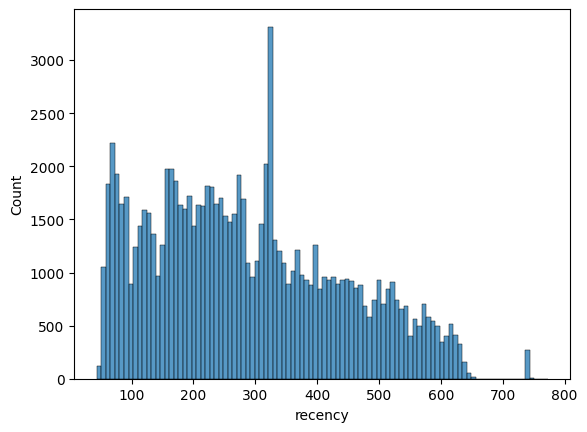

In [11]:
sns.histplot(data=crfm, x = 'recency',bins = 100)

In [12]:
print([x for x in range(10,0,-1)])

[10, 9, 8, 7, 6, 5, 4, 3, 2, 1]


In [13]:
n = 5
crfm['R_score'] = pd.qcut(crfm['recency'],n,labels=[x for x in range(n,0,-1)])

In [ ]:
summary_cuts = crfm.groupby('R_score')['recency'].agg(['min', 'max', 'count', 'mean','median'])
summary_cuts.sort_index(ascending=False)

,min,max,count,mean,median
R_score,,,,,
1,433,773,18968,523.385966,516.0
2,318,432,18929,365.841407,363.0
3,227,317,19007,269.615931,268.0
4,143,226,18952,185.071655,184.0
5,44,142,19133,94.595725,91.0


C:\Users\Domakei\AppData\Local\Temp\ipykernel_5404\2384348273.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='R_score', y='recency', data=crfm, palette='viridis')


<Axes: xlabel='R_score', ylabel='recency'>

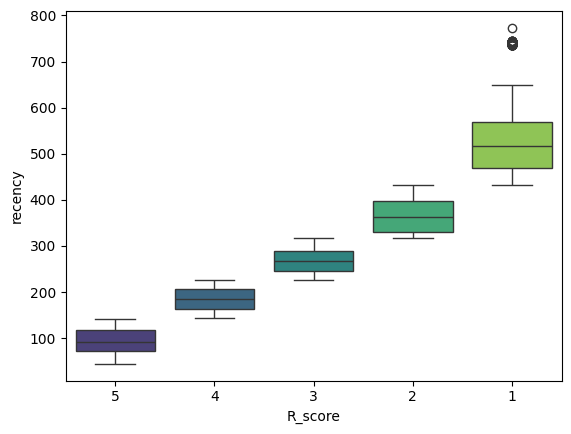

In [15]:
sns.boxplot(x='R_score', y='recency', data=crfm, palette='viridis')

<Axes: xlabel='R_score', ylabel='count'>

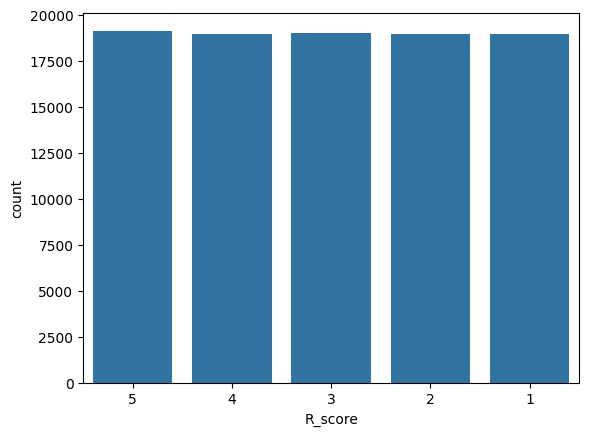

In [16]:
sns.countplot(data=crfm,x = 'R_score')

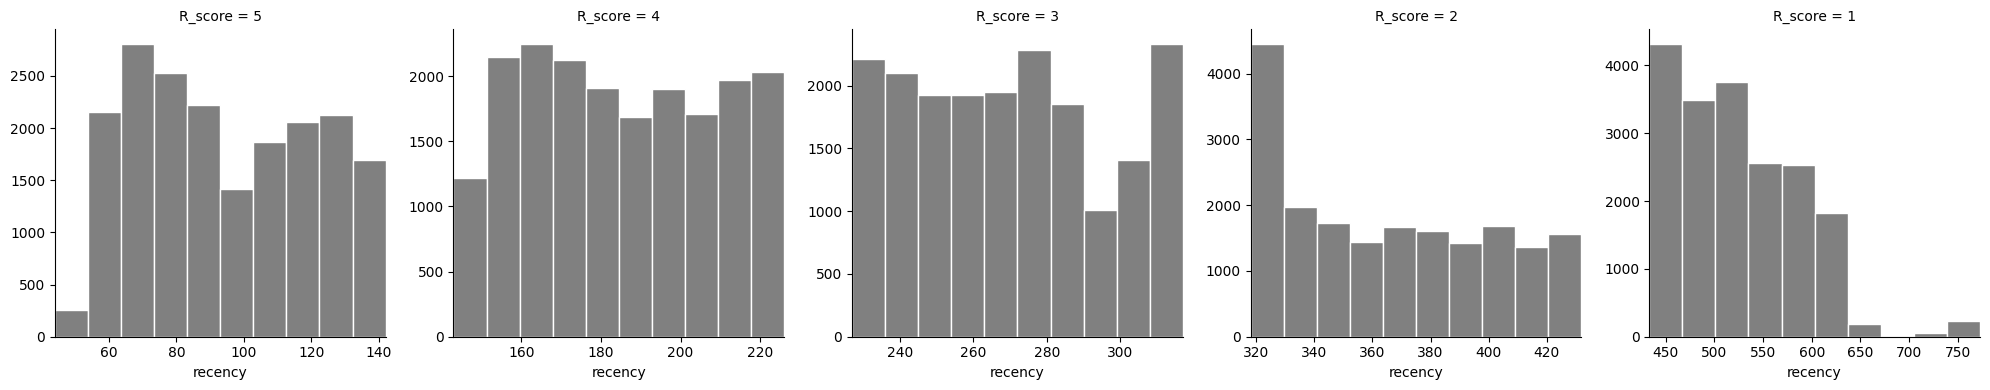

In [82]:
g = sns.FacetGrid(crfm, col="R_score", sharey=False, sharex=False, height=4)
g.map(plt.hist, "recency", bins=10, color='gray', edgecolor='white')


for ax in g.axes.flat:
    ax.margins(x=0)

plt.show()

## Frequency

<Axes: xlabel='frequency', ylabel='count'>

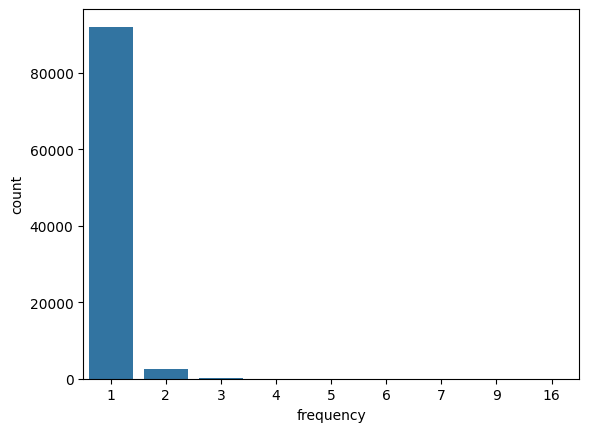

In [18]:
sns.countplot(data = crfm, x = 'frequency')

Para este caso, no se puede usar quintiles, pues los datos son extremadamente sesgados a la derecha (hay muchisima más cantidad de personas que solo han comprado una vez), usar quintiles solo provocaría que los scores de 1 a 4 estén completamente llenos de 1

In [19]:
crfm['frequency'].value_counts()

frequency
1     92101
2      2652
3       188
4        29
5         9
6         5
7         3
9         1
16        1
Name: count, dtype: int64

Viendo estos datos, notamos como el 96.95% de los clientes han comprado una sola vez, apenas el 2.7% compraron dos veces y menos del 0.3% han comprado más de dos veces, por lo que para estos datos es mejor realizar una segmentación manual, tomando las siguientes decisiones
|F_score|Intervalo|
|---|---|
|1| frequency = 1|
|3| frequency = 2|
|4| frequency = 3|
|5| frequency > 3|

In [21]:
crfm['F_score'] = crfm['frequency'].apply(lambda x: 1 if x == 1 else (3 if x == 2 else (4 if x==3 else 5)))

In [24]:
crfm['F_score'].value_counts()

F_score
1    92101
3     2652
4      188
5       48
Name: count, dtype: int64

## Monetary

<Axes: xlabel='monetary', ylabel='Count'>

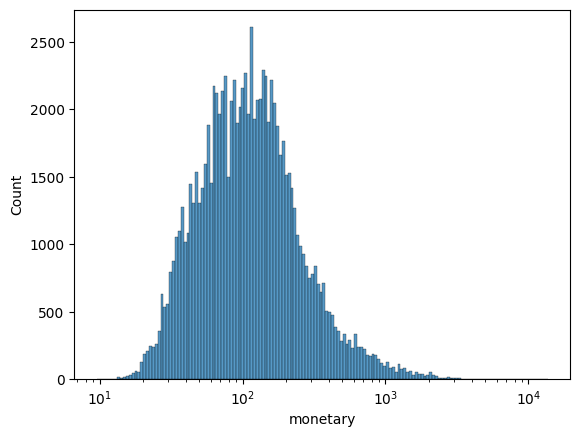

In [84]:
sns.histplot(data = crfm, x = 'monetary', log_scale=True)

Claramente hay un punto atípico que impide ver correctamente como se distribuye esta variable

In [33]:
crfm.sort_values(by = 'monetary',ascending=False)

,customer_unique_id,recency,frequency,monetary,R_score,F_score
49343,0a0a92112bd4c708ca5fde585afaa872,383,1,13664.08,2,1
88024,da122df9eeddfedc1dc1f5349a1a690c,564,2,7571.63,1,3
69524,763c8b1c9c68a0229c42c9fc6f662b93,94,1,7274.88,5,1
88450,dc4802a71eae9be1dd28f5d788ceb526,612,1,6929.31,1,1
60388,459bef486812aa25204be022145caa62,84,1,6922.21,5,1
...,...,...,...,...,...,...
55028,2878e5b88167faab17d4fb83a986d38b,353,1,11.63,2,1
20592,6f5b9d1cdccc4d28f0483a612edecacf,410,1,11.63,2,1
33300,b33336f46234b24a613ad9064d13106d,118,1,10.89,5,1
82546,bd06ce0e06ad77a7f681f1a4960a3cc6,399,1,10.07,2,1


<Axes: xlabel='monetary', ylabel='Count'>

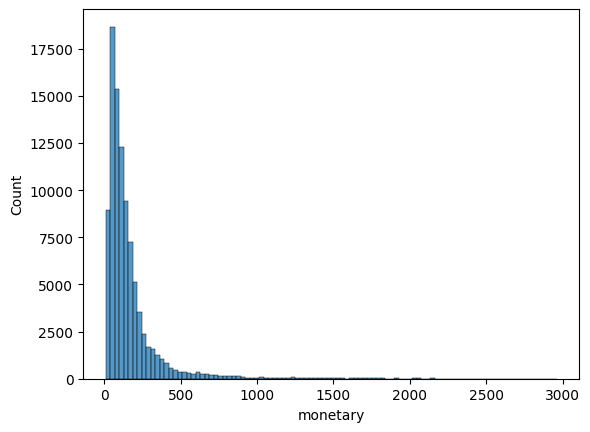

In [49]:
sns.histplot(data = crfm[crfm['monetary'] < 3000].copy(), x = 'monetary',bins = 100)

In [50]:
crfm['monetary'].agg(['min', 'max', 'count', 'mean','median'])

min           9.590000
max       13664.080000
count     94989.000000
mean        165.694312
median      107.900000
Name: monetary, dtype: float64

Como vemos, la información es altamente asimétrica hacia la derecha. De todas formas, los outliers no suelen afectar mucho el uso de cuantiles para segmentar esta información.

In [52]:
n = 5
crfm['M_score'] = pd.qcut(crfm['monetary'],n,labels=[x for x in range(1,n+1)])

In [55]:
crfm.groupby('M_score')['monetary'].agg(['min', 'max', 'count', 'mean','median']).sort_index(ascending=False)

,min,max,count,mean,median
M_score,,,,,
5,209.15,13664.08,18996,443.883217,318.97
4,133.06,209.12,19000,165.542564,163.28
3,87.52,133.05,18994,108.700735,107.92
2,55.37,87.51,18998,70.640398,70.03
1,9.59,55.36,19001,39.741837,40.13


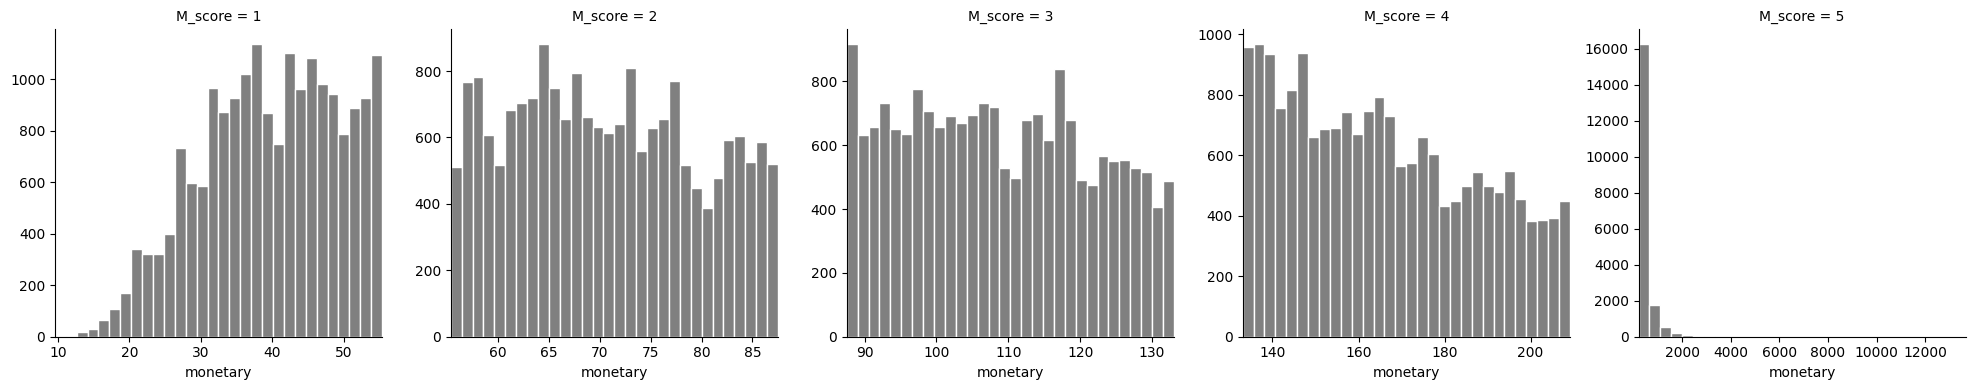

In [83]:
g = sns.FacetGrid(crfm, col="M_score", sharey=False, sharex=False, height=4)
g.map(plt.hist, "monetary", bins=30, color='gray', edgecolor='white')


for ax in g.axes.flat:
    ax.margins(x=0)

plt.show()

Se muestra como los M_score centrales no parecen estar sesgados, mientras que los score de 1 y 2 están sesgados a la izquierda y derecha respectivamente.

## Análisis multivariado entre R, F y M